In [1]:
from auxiliary.ds import DataLoader
from auxiliary.logger import log

# from kaggle: This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015

_kaggle_path = "harlfoxem/housesalesprediction"
df = DataLoader.from_kaggle_path(_kaggle_path).data
log(f'Dataset from "{_kaggle_path}":')
log(f"{df.head()}")
log(f"Number of entries in dataframe: {len(df)}")

2025-03-13 22:53:38,657 [INFO ] Dataset from "harlfoxem/housesalesprediction":
2025-03-13 22:53:38,670 [INFO ]            id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0 

In [2]:
import pandas as pd
from homeworks.hw5.utils import get_house_age
from auxiliary.ds import get_preprocessed_with_one_hot_enc, get_preprocessed_with_label_enc

log(f"Filtering out rows with nan's (however there are none)")
log(f"Number of entries in dataframe before filtering: {len(df)}")
df.dropna(how='any', inplace=True)
log(f"Number of entries in dataframe after filtering: {len(df)}")

log("Removing 'id' and 'date' column, adding 'age' column")
dates = df['date']
df_ages = pd.DataFrame({'age': dates.apply(get_house_age)})
for col_to_remove in ('id', 'date'):
    df.drop(col_to_remove, axis=1, inplace=True)
df = pd.concat([df, df_ages], axis=1)
df.head()

2025-03-13 22:53:38,684 [INFO ] Filtering out rows with nan's (however there are none)
2025-03-13 22:53:38,685 [INFO ] Number of entries in dataframe before filtering: 21613
2025-03-13 22:53:38,691 [INFO ] Number of entries in dataframe after filtering: 21613
2025-03-13 22:53:38,693 [INFO ] Removing 'id' and 'date' column, adding 'age' column


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0.632877
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,0.476712
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,0.263014
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,0.476712
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,0.282192


In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from homeworks.hw5.config import TARGET_VAR

log("Removing anomalies using percentiles")
margin = 5
value_pct = (margin, 100 - margin)
prices = df[TARGET_VAR]
border_l, border_r = tuple(np.percentile(prices, pct) for pct in value_pct)
df = df.loc[np.logical_and(df[TARGET_VAR] >= border_l, df[TARGET_VAR] <= border_r)]
log(f"After removing values which don't fit in {value_pct[0]}-{value_pct[1]}% range, dataframe has {len(df)} entries")

log("Scaling data")
scaler = StandardScaler()
df_arr = scaler.fit_transform(df)
df = pd.DataFrame(df_arr, index=df.index, columns=df.columns)

log("Splitting dataframe into source/target")
X = df.drop(TARGET_VAR, axis=1)
y = df[TARGET_VAR]

2025-03-13 22:53:39,261 [INFO ] Removing anomalies using percentiles
2025-03-13 22:53:39,270 [INFO ] After removing values which don't fit in 5-95% range, dataframe has 19511 entries
2025-03-13 22:53:39,272 [INFO ] Scaling data
2025-03-13 22:53:39,289 [INFO ] Splitting dataframe into source/target


In [4]:
from auxiliary.ds.utils import get_variable_combinations, get_most_correlated_variables
from homeworks.hw5.config import FEATURES_COUNT

log('Creating a list of x-y correlations, where x is any column from X')
correlations_Xy = get_most_correlated_variables(X, y)[:FEATURES_COUNT]
cols, corrs = zip(*correlations_Xy)
new_combinations = get_variable_combinations(cols)

log('For these new combinations, let\'s add features to new dataframe features_df:')
log(f"Number of X columns (before adding features): {len(X.columns)}")
features_df = pd.DataFrame({f'{col1}_X_{col2}': X[col1] * X[col2] for col1, col2 in new_combinations})
correlations_fy = get_most_correlated_variables(features_df, y)[:FEATURES_COUNT]

Xf = pd.concat((X, features_df), axis=1)
log(f"Number of Xf columns (after adding features): {len(Xf.columns)}")

2025-03-13 22:53:39,301 [INFO ] Creating a list of x-y correlations, where x is any column from X
2025-03-13 22:53:39,314 [INFO ] 10 variables most correlated with target variable are:
2025-03-13 22:53:39,316 [INFO ]   grade: 0.6105292137787415
2025-03-13 22:53:39,317 [INFO ]   sqft_living: 0.5996821008543273
2025-03-13 22:53:39,318 [INFO ]   sqft_living15: 0.5428971324851585
2025-03-13 22:53:39,319 [INFO ]   sqft_above: 0.5103601977493712
2025-03-13 22:53:39,320 [INFO ]   bathrooms: 0.41587603861535855
2025-03-13 22:53:39,321 [INFO ]   lat: 0.3902769030435398
2025-03-13 22:53:39,322 [INFO ]   bedrooms: 0.27021934858582464
2025-03-13 22:53:39,323 [INFO ]   floors: 0.23971452049329076
2025-03-13 22:53:39,324 [INFO ]   view: 0.23862441105012813
2025-03-13 22:53:39,325 [INFO ]   sqft_basement: 0.2150973216153561
2025-03-13 22:53:39,326 [INFO ] For these new combinations, let's add features to new dataframe features_df:
2025-03-13 22:53:39,327 [INFO ] Number of X columns (before adding fea

In [5]:
from sklearn.model_selection import train_test_split
from homeworks.hw5.config import TEST_RATIO

log('Making train/test splits')
X_train, X_test, Xf_train, Xf_test, y_train, y_test = train_test_split(X, Xf, y, test_size=TEST_RATIO)
for name in ('X_train', 'Xf_train', 'y_train', 'X_test', 'Xf_test', 'y_test'):
    log(f'{name} shape: {eval(name).shape}')

2025-03-13 22:53:39,395 [INFO ] Making train/test splits
2025-03-13 22:53:39,420 [INFO ] X_train shape: (15608, 19)
2025-03-13 22:53:39,422 [INFO ] Xf_train shape: (15608, 68)
2025-03-13 22:53:39,423 [INFO ] y_train shape: (15608,)
2025-03-13 22:53:39,424 [INFO ] X_test shape: (3903, 19)
2025-03-13 22:53:39,425 [INFO ] Xf_test shape: (3903, 68)
2025-03-13 22:53:39,426 [INFO ] y_test shape: (3903,)


In [6]:
import numpy as np
from homeworks.hw5.config import MAP_GRID_SEARCH_PARAMS
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from auxiliary.ds.fit import fit_with_grid_search


map_grid_cv_results = {}
for regr_cls, params in MAP_GRID_SEARCH_PARAMS.items():
    for case, source_train, source_test in (
        ('non-FE', X_train, X_test),
        ('FE', Xf_train, Xf_test),
    ):
        log(f'Training {regr_cls.__name__} regressor on {case} dataframe.')
        search_res = fit_with_grid_search(regr_cls, params, source_train, y_train)
        best_regr = search_res.best_estimator_
        map_grid_cv_results.setdefault(regr_cls, {})[case] = {
            'search': search_res,
            'best_regr': best_regr,
        }
        for loss_name, x, y in (
            ('train', source_train, y_train),
            ('test', source_test, y_test),
        ):
            y_pred = best_regr.predict(x)
            mae = mean_absolute_error(y, y_pred)
            mse = mean_squared_error(y, y_pred)
            rmse = np.sqrt(mse)
            log(f'{loss_name} MAE: {mae}')
            log(f'{loss_name} MSE: {mse}')
            log(f'{loss_name} RMSE: {rmse}')
            map_grid_cv_results[regr_cls][case].update({
                f'{loss_name}_mae': mae,
                f'{loss_name}_mse': mse,
                f'{loss_name}_rmse': rmse,
            })

2025-03-13 22:53:39,446 [INFO ] Training Ridge regressor on non-FE dataframe.
2025-03-13 22:53:39,448 [INFO ] Doing grid search with Ridge and params: {'alpha': array([0.5, 1. , 1.5])}
2025-03-13 22:53:39,601 [INFO ] Done in 0.15369716100030928 s
2025-03-13 22:53:39,607 [INFO ] train MAE: 0.4302138274740088
2025-03-13 22:53:39,609 [INFO ] train MSE: 0.32575284078998784
2025-03-13 22:53:39,609 [INFO ] train RMSE: 0.57074761566737
2025-03-13 22:53:39,615 [INFO ] test MAE: 0.43067702070463976
2025-03-13 22:53:39,616 [INFO ] test MSE: 0.3157127776767261
2025-03-13 22:53:39,617 [INFO ] test RMSE: 0.5618832420322981
2025-03-13 22:53:39,618 [INFO ] Training Ridge regressor on FE dataframe.
2025-03-13 22:53:39,619 [INFO ] Doing grid search with Ridge and params: {'alpha': array([0.5, 1. , 1.5])}
2025-03-13 22:53:40,029 [INFO ] Done in 0.41029196999988926 s
2025-03-13 22:53:40,036 [INFO ] train MAE: 0.39787929037214187
2025-03-13 22:53:40,038 [INFO ] train MSE: 0.2798982445171846
2025-03-13 22:

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 12486, number of used features: 19
[LightGBM] [Info] Start training from score 0.002487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2520
[LightGBM] [Info] Number of data points in the train set: 12486, number of used features: 19
[LightGBM] [Info] Start training from score -0.002268
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2515
[LightGBM] [Info] Number of data points in the train se

2025-03-13 22:58:29,182 [INFO ] Done in 1.5287143160003325 s
2025-03-13 22:58:29,191 [INFO ] train MAE: 0.17303995363914898
2025-03-13 22:58:29,192 [INFO ] train MSE: 0.05498906449145653
2025-03-13 22:58:29,193 [INFO ] train RMSE: 0.23449747224960982
2025-03-13 22:58:29,198 [INFO ] test MAE: 0.26326789518016364
2025-03-13 22:58:29,199 [INFO ] test MSE: 0.1414497517657033
2025-03-13 22:58:29,200 [INFO ] test RMSE: 0.37609806136924356
2025-03-13 22:58:29,200 [INFO ] Training LGBMRegressor regressor on FE dataframe.
2025-03-13 22:58:29,201 [INFO ] Doing grid search with LGBMRegressor and params: {'n_estimators': array([ 75, 125], dtype=uint8), 'learning_rate': array([0.5, 1.5])}


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2529
[LightGBM] [Info] Number of data points in the train set: 15608, number of used features: 19
[LightGBM] [Info] Start training from score 0.001657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11682
[LightGBM] [Info] Number of data points in the train set: 12486, number of used features: 68
[LightGBM] [Info] Start training from score 0.002487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11696
[LightGBM] [Info] Number of data points in the train s

2025-03-13 22:58:32,318 [INFO ] Done in 3.1164439390013285 s
2025-03-13 22:58:32,330 [INFO ] train MAE: 0.16001469800299103
2025-03-13 22:58:32,331 [INFO ] train MSE: 0.04659551062122148
2025-03-13 22:58:32,331 [INFO ] train RMSE: 0.2158599328759774
2025-03-13 22:58:32,336 [INFO ] test MAE: 0.2668239208436998
2025-03-13 22:58:32,337 [INFO ] test MSE: 0.14784154222216392
2025-03-13 22:58:32,337 [INFO ] test RMSE: 0.384501680389259
2025-03-13 22:58:32,338 [INFO ] Training ExtraTreesRegressor regressor on non-FE dataframe.
2025-03-13 22:58:32,339 [INFO ] Doing grid search with ExtraTreesRegressor and params: {'n_estimators': array([ 75, 112, 150], dtype=uint8)}
2025-03-13 22:59:35,736 [INFO ] Done in 63.397536027998285 s
2025-03-13 22:59:36,176 [INFO ] train MAE: 6.408781182068985e-07
2025-03-13 22:59:36,176 [INFO ] train MSE: 3.205296031670146e-09
2025-03-13 22:59:36,177 [INFO ] train RMSE: 5.661533389171299e-05
2025-03-13 22:59:36,331 [INFO ] test MAE: 0.2514520707076197
2025-03-13 22:5

2025-03-13 23:03:01,683 [INFO ] Creating scatter plots of predicted values for different regressor classes


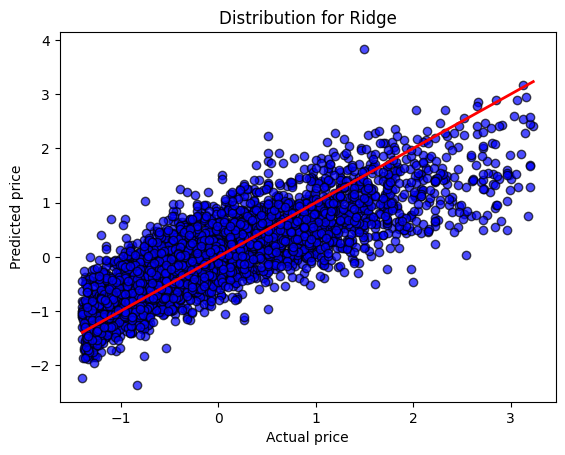

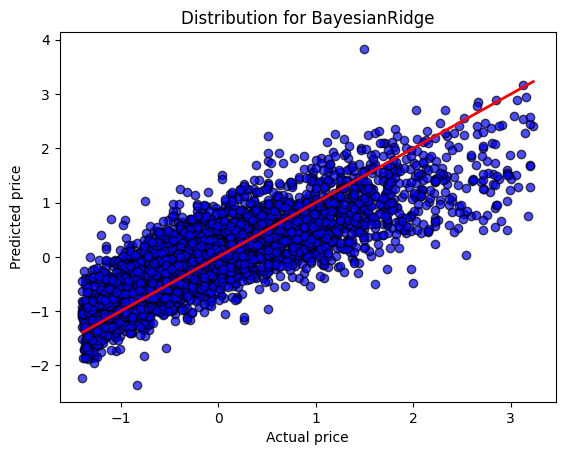

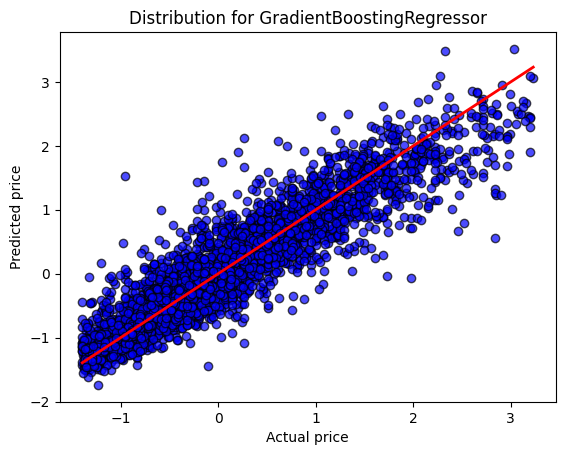

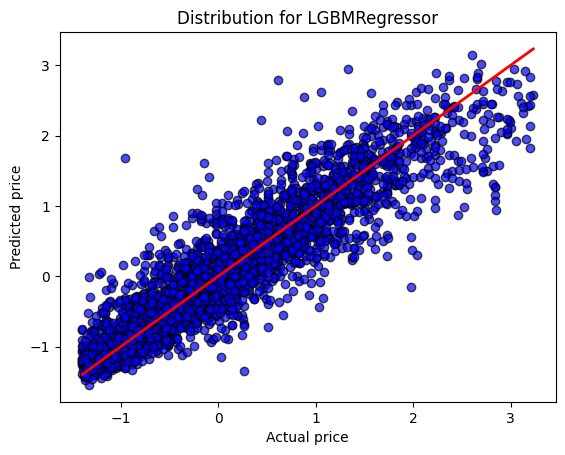

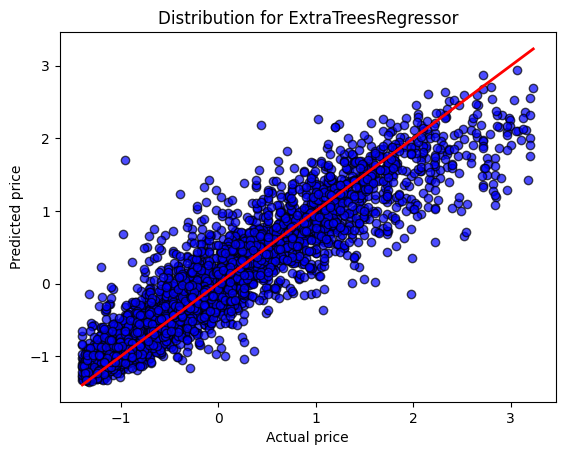

In [7]:
import matplotlib.pyplot as plt

log("Creating scatter plots of predicted values for different regressor classes")

for cls, val in map_grid_cv_results.items():
    y_pred = val['non-FE']['best_regr'].predict(X_test)
    plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
    plt.xlabel(f"Actual {TARGET_VAR}")
    plt.ylabel(f"Predicted {TARGET_VAR}")
    plt.title(f"Distribution for {cls.__name__}")
    plt.show()

2025-03-13 23:03:02,402 [INFO ] Visualization of MAE values for different regressors
2025-03-13 23:03:02,453 [INFO ] Feature engineering wasn't successful for GradientBoosting, LGBM and ExtraTrees regressors, however for simpler regressors like Ridge/Bayesian Ridge it was substantial.


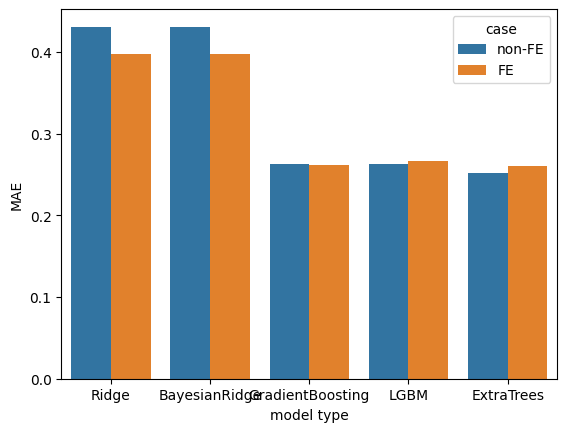

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

log('Visualization of MAE values for different regressors')
_cases = ('non-FE', 'FE')
aux_df = pd.DataFrame([
    {'model type': cls.__name__.replace('Regressor', ''), 'case': case, 'MAE': val[case]['test_mae']} 
    for cls, val in map_grid_cv_results.items() for case in _cases
])
sns.barplot(aux_df, x='model type', y='MAE', hue='case')
log("Feature engineering wasn't successful for GradientBoosting, LGBM and ExtraTrees regressors, however for simpler regressors like Ridge/Bayesian Ridge it was substantial.")

2025-03-13 23:03:02,535 [INFO ] Plotting train/test errors to get understanding which of regression models suffers most from overfitting
2025-03-13 23:03:02,579 [INFO ] And the winner is ExtraTrees if one sorts by test_MAE/train_MAE ratio.


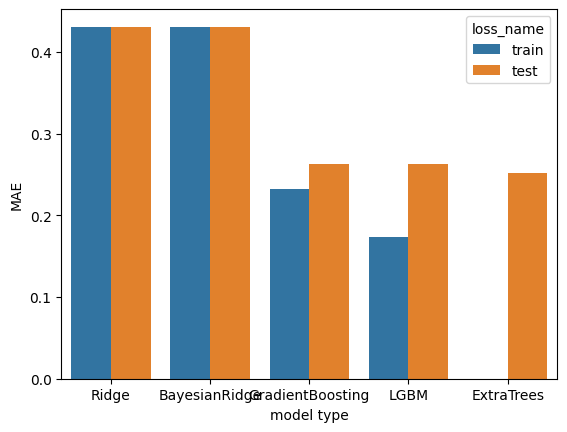

In [9]:
log("Plotting train/test errors to get understanding which of regression models suffers most from overfitting")
aux_df = pd.DataFrame([
    {'model type': cls.__name__.replace('Regressor', ''), 'loss_name': loss_name, 'MAE': val['non-FE'][f'{loss_name}_mae']} 
    for cls, val in map_grid_cv_results.items() for loss_name in ('train', 'test')
])
sns.barplot(aux_df, x='model type', y='MAE', hue='loss_name')
log("And the winner is ExtraTrees if one sorts by test_MAE/train_MAE ratio.")